# PCA Autoencoder (Part I)

An [interesting work](https://arxiv.org/abs/1904.01277) by Ladjal et al on autoencoders has been brought to my attention by one of my colleagues, as we are trying to leverage the nonlinearity of autoencoders to better decompose complex turbulent reacting flows. As stated in the abstract, the main goal was to improve the interpretability of autoencoder by (1) constructing the latent space of the autoencoder with independent components that are (2) ordered by decreasing importance to the data (both are automatically achieved with a linear Principal Component Analysis). To achieve (1), the authors proposed to minimize the covariance of the latent codes alongside the standard loss function. The covariance term can be written as (based on Eq.1 in the paper):

$$
\Lambda_{conv}(X)=\lambda\sum_{i=1}^{k-1}\left[\frac{1}{M}\sum_{j=1}^{M}\left(z_i^jz_k^j\right) - \frac{1}{M^2}\sum_{j=1}^{M}\left(z_i^j\right)\sum_{j=1}^{M}\left(z_k^j\right)\right]
$$

where $M$ is the batch size, $z_i$ the code in the latent space. The authors introduced two modifications to a conventional CNN-based autoencoder to implement this loss function: 

- First, a BatchNormalization layer before the latent space (such that the second term above becomes 0)
- Second, add the rest of the covariance term to the total loss

I will attempt to reproduce some of the key results presented in the paper in a two-part series using TensorFlow. In this notebook, I will focus on implementing the new loss function, utilizing the `.add_loss()` method in custom layers in TensorFlow.  In the second part, I will look at how to achieve a hiearchichal latent space with the iterations the authors described. I will refer to the architecture as **PCA autoencoder**, a term given by the authors in their paper.

## Synthesize dataset

In this notebook, I will just try to recreate the set of binary ellipses with only two variables (two variables) and leave out the rotation for the time being.

### Setup

In [ ]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


np.random.seed(42)
tf.random.set_seed(42)

### Phantom binary ellipses

I will use the same image dimension (64, 64) as stated in the paper. With a batch size of 500, I chose a sample size of 8000 to get 16 minibatches per epoch (it seems the total sample size was not provided in the paper, unless I missed it).

In [ ]:
def phantomEllipse(n, a, b):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return img

In [ ]:
n = 64
num_batch = 16
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
dataset = np.array([phantomEllipse(n, _a, _b) for _a, _b in zip(a, b)])
dataset = dataset[..., np.newaxis]  # pay attention to the shape of the dataset!

Let's look at a sample of 8 images from the dataset:

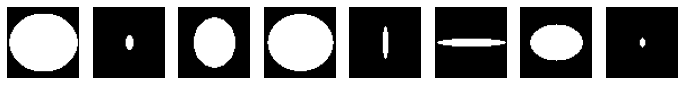

In [ ]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

As can be seen, the ellipses have essentially two degrees of freedom (horizontal and vertical axes). Ideally, a latent space containing two codes in the autoencoder should suffice to capture these two main features in the dataset. Let's see what a traditional CNN-autoencoder could do.

## PCA Autoencoder

I will not strictly follow model structure presented in the paper. I will adopt a more conventional "pyramid" architecture with increasing filters in the encoder hidden layers (and vice versa for the decoder). The goal here is not to optimize the autoencoder to minimize the losses. The focus is rather on the functional differences between autoencoder and PCA encoder introduced by the authors.

### Covariance loss

To implement the additional covariance loss term, a custom layer will be created for utilizing the `.add_loss()` method built into the standard `keras.layers.Layer`. 

In [ ]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam
    def call(self, inputs):
        covariance = self.lam * tf.math.reduce_mean(tf.math.reduce_prod(inputs, 1))
        self.add_loss(tf.math.abs(covariance))
        return inputs
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "lam":self.lam,}

### Enconder

To neutralize the second term in the covariance loss (see above), a non-trainable BatchNormalization layer needs to be added prior to the latent space. The training of $\gamma$ and $\beta$ will therefore be disabled by setting both keyword arguments `scale` and `center` to **False**.

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Conv2D(4, (3, 3), padding='same', input_shape=[64, 64, 1]),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(scale=False, center=False),
    keras.layers.Dense(2),
    keras.layers.LeakyReLU(),
    LatentCovarianceLayer(0.1)    
])

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         296       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1

### Decoder

Instead of a combinationation of Conv2D and upsampling layers, I will just use Conv2DTranspose to simplify the decoder.

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[2]),
    keras.layers.LeakyReLU(),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'),
])

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 32)          1184      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 16)          4624      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 16)         

### Compile and train

In [ ]:
# SCROLL
keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae = keras.models.Sequential([encoder, decoder])
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_pca_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 4s 29ms/step - loss: 0.2136

Epoch 00001: loss improved from inf to 0.21358, saving model to ./model_pca_ae.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 28ms/step - loss: 0.1815

Epoch 00002: loss improved from 0.21358 to 0.18147, saving model to ./model_pca_ae.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 29ms/step - loss: 0.1620

Epoch 00003: loss improved from 0.18147 to 0.16198, saving model to ./model_pca_ae.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 28ms/step - loss: 0.1137

Epoch 00004: loss improved from 0.16198 to 0.11374, saving model to ./model_pca_ae.hdf5
Epoch 5/1000
16/16 [==============================] - 0s 29ms/step - loss: 0.0751

Epoch 00005: loss improved from 0.11374 to 0.07507, saving model to ./model_pca_ae.hdf5
Epoch 6/1000
16/16 [==============================] - 0s 29ms/step - loss: 0.0592

Epoch 00006: loss improved from 0.07507 to 0.05918, saving model t

### Examine the results

Let's load the best model and test it on a frame first.

In [ ]:
pca_ae_model = keras.models.load_model('model_pca_ae.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

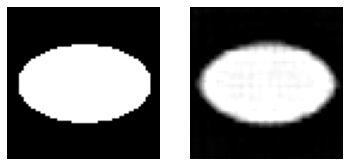

In [ ]:
img = dataset[1430, ...]
img_rec = pca_ae_model.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

Alright, the model seems to work as it is supposed to. Due to limited latent codes and the fact that the binary nature of the datasets has not been enforced during training (such as via sigmoid activation and/or binary cross entropy), the autoencoder couldn't perfectly reproduce the original image. The compression is likely too lossy. Let's now try to look at the interdepencies of the two codes in the latent space (Fig.2 in the original paper), which the authors referred to as the "interpolation" by fixing either one of the coordinates to 0. We can do that by extracting the decoder from the model:

In [ ]:
pca_ae_decoder = pca_ae_model.layers[1]

and then supply different coordinates to it:

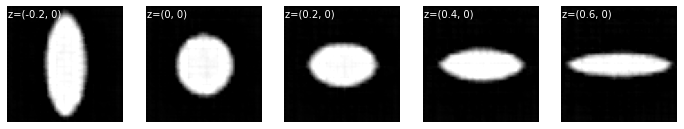

In [ ]:
vals = [-0.2, 0, 0.2, 0.4, 0.6]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()


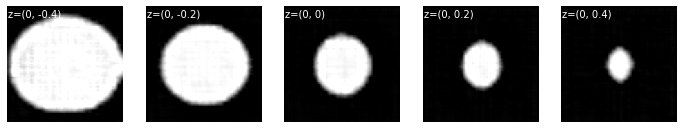

In [ ]:
vals = [-0.4, -0.2, 0, 0.2, 0.4]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

It appears that, even without the iterative hierarchical model the authors adopted, the two codes in the latent space have attained distinct roles in representing the input image: with the first code controlling the axis and the second controlling the size of the ellipses.

### Remarks

It should be pointed out that I tried a variety of models with different constellations of hidden layers and activation functions (such as ReLU, UpSampling2D). Although the above model doesn't generate the most accurate input image, it produces the most consistent latent space that contains relatively independent codes.

I also tried to use just the custom layer to compute the entire covariance loss, instead of relying on the BatchNormalization layer to set the batch average to 0. However, it seems this separate approach as adopted by the authors consistently produced the best results (desired latent codes) during my tests and also ran faster. It is possible that the BatchNormalization layer serves more purposes (such as controlling the gradient) than intended that could have benefited the training. 

## CNN Autoencoder

For comparison, we will have a look at a conventional autoencoder without the custom layer to account for latent covariance. I will keep all the other layers the same (including the BatchNormalization to ensure similar values in the latent space).

In [ ]:
# SCROLL
encoder = keras.models.Sequential([
    keras.layers.Conv2D(4, (3, 3), padding='same', input_shape=[64, 64, 1]),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(scale=False, center=False),
    keras.layers.Dense(2),
    keras.layers.LeakyReLU(),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[2]),
    keras.layers.LeakyReLU(),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(16, (3, 3),  strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'),
])

keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae = keras.models.Sequential([encoder, decoder])
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 1s 36ms/step - loss: 0.1892

Epoch 00001: loss improved from inf to 0.18923, saving model to ./model_pca_ae.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.1216

Epoch 00002: loss improved from 0.18923 to 0.12158, saving model to ./model_pca_ae.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.0792

Epoch 00003: loss improved from 0.12158 to 0.07916, saving model to ./model_pca_ae.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.0598

Epoch 00004: loss improved from 0.07916 to 0.05977, saving model to ./model_pca_ae.hdf5
Epoch 5/1000
16/16 [==============================] - 0s 28ms/step - loss: 0.0524

Epoch 00005: loss improved from 0.05977 to 0.05238, saving model to ./model_pca_ae.hdf5
Epoch 6/1000
16/16 [==============================] - 0s 29ms/step - loss: 0.0498

Epoch 00006: loss improved from 0.05238 to 0.04985, saving model t

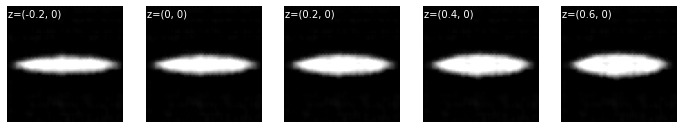

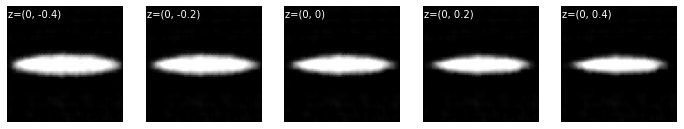

In [ ]:
ae_model = keras.models.load_model('model_ae.hdf5')
ae_decoder = ae_model.layers[1]
vals = [-0.2, 0, 0.2, 0.4, 0.6]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

vals = [-0.4, -0.2, 0, 0.2, 0.4]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

It is clear that without minimizing the covariance losses, the standard autoencoder is not able to separate the features in the datasets.